<a href="https://colab.research.google.com/github/blancavazquez/DAMA_EHR19/blob/master/notebooks/EHR_taller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de mortalidad hospitalaria
## Blanca Hilda Vázquez Gómez

**Objetivo:** Implementar un modelo que permita predecir mortalidad hospitalaria en una Unidad de Cuidados Intensivos. 

**¿Por qué desarrollar modelos para predecir mortalidad?**

El desarrollo de métodos para predecir las tasas de mortalidad en las poblaciones de la Unidad de Cuidados Intensivos (UCI) ha sido motivado principalmente por:
- La necesidad de comparar la eficacia de los medicamentos, las pautas de atención, cirugías e  intervenciones. 
- Controlar las diferencias entre la gravedad de una enfermedad o trauma, edad y otros factores.
 
Por ejemplo: comparar tasas generales de mortalidad entre las unidades de trauma de un hospital comunitario, un hospital universitario y un hospital de campaña militar, como resultado es probable que refleje las diferencias en las poblaciones de pacientes más que cualquier diferencia en los estándares de atención.

**Descripción de la base de datos**

Para llevar a cabo este ejemplo, se empleará la base de datos que se usó en el "The PhysioNet/Computing in Cardiology Challenge 2012". La base de datos tiene las siguientes características generales:

- Cuenta con 12,000 registros de admisiones.
- Las admisiones corresponden a las unidades de cuidados intensivos: cardíacas, médicas, quirúrgicas y traumatológicas.
- Se registraron 42* variables clínicas durante las primeras 48 horas de admisión a la ICU.
- De las 42 variables, 6 son descriptores y fueron recolectados al momento de la admisión, las variables restantes son series de tiempo.


In [0]:
#!rm -r DAMA_EHR19
!git clone https://github.com/blancavazquez/DAMA_EHR19.git

Cloning into 'DAMA_EHR19'...
remote: Enumerating objects: 8061, done.
remote: Counting objects: 100% (8061/8061), done.
remote: Compressing objects: 100% (8049/8049), done.
remote: Total 8061 (delta 11), reused 8009 (delta 3), pack-reused 0
Receiving objects: 100% (8061/8061), 37.46 MiB | 5.99 MiB/s, done.
Resolving deltas: 100% (11/11), done.


## Paso 1: Carga de datos
El primer paso a realizar será cargar nuestros datos.

In [0]:
import csv
import numpy as np
import pandas as pd
from collections import defaultdict
import os

filepath_patients = '/content/DAMA_EHR19/data/set-a_b' #datos
filepath_outcomes = '/content/DAMA_EHR19/data/Outcomes-a_b.csv' # labels

def read_data(filepath):
    """ Función para visualizar el contenido de la base de datos"""
    data = pd.read_csv(filepath)
    return data

#Visualizando el archivo 'Outcomes-a_b.csv'
outcomes = read_data(filepath_outcomes)
print(outcomes.head()) #return the first 5 rows

   RecordID  SAPS-I  SOFA  Length_of_stay  Survival  In-hospital_death
0    132539       6     1               5        -1                  0
1    132540      16     8               8        -1                  0
2    132541      21    11              19        -1                  0
3    132543       7     1               9       575                  0
4    132545      17     2               4       918                  0


In [0]:
#Visualizando el archivo 'Outcomes-a_b.csv'
pat_132539 = read_data('/content/DAMA_EHR19/data/set-a_b/132539.txt')
print(pat_132539.head(10))#regresa las primeras 10 filas

/content
    Time  Parameter      Value
0  00:00   RecordID  132539.00
1  00:00        Age      54.00
2  00:00     Gender       0.00
3  00:00     Height      -1.00
4  00:00    ICUType       4.00
5  00:00     Weight      -1.00
6  00:07        GCS      15.00
7  00:07         HR      73.00
8  00:07  NIDiasABP      65.00
9  00:07      NIMAP      92.33


In [0]:
print(pat_132539.tail())#regresa las últimas 5 filas

      Time Parameter   Value
268  47:37     NIMAP   79.33
269  47:37  NISysABP  128.00
270  47:37  RespRate   23.00
271  47:37      Temp   37.80
272  47:37     Urine  280.00


## Paso 2:  Construcción de diccionarios
Vamos a construir estructuras de datos para guardar la información de los pacientes para posteriormente analizar los datos

In [0]:
def dict_outcomes(path_outcomes):
    """ Crea un diccionario a partir de los datos en el archivo "Outcomes" """ 
    with open(path_outcomes) as file:
        input = csv.reader(file)
        next(input) # salta la primera fila y se mueve a la siguiente
        outcomes = defaultdict(list)
        for row in input:
            outcomes[row[0]] = row
        return outcomes

#Construimos un diccionario para extraer las etiquetas de cada paciente
outcomes={}
outcomes = dict_outcomes(filepath_outcomes)

#outcomes={}
#dict_outcomes(filepath_y_test)

In [0]:
def read_pat(filepath_patients,icustay):
    """ Crea un diccionario para almacenar los valores de las estancias"""
    data_icu = {}
    for icustay_id in icustay.keys():
        file = '{}.txt'.format(icustay_id)
        f = open(os.path.join(filepath_patients,file))
        read_data = csv.reader(f)
        next(read_data) #salta la primera fila y se mueve a la siguiente
        next(read_data) #salta la fila "recordID"
        data = defaultdict(list)
        for row in read_data:
            data[row[1]].append((row[0],row[2]))
            data_icu[icustay_id] = data
    return data_icu

data_icu = read_pat(filepath_patients,outcomes) #salida: 'BUN': [('10:37', '13'), ('33:07', '8')]

## Paso 3: Análisis de datos
A partir de las estructuradas creadas previamente, procedemos a analizar cada variable clínica

In [0]:
#Paso 3: Análisis de datos
vars_estaticas = ['Age', 'Gender', 'Height', 'ICUType']
vars_dinamicas = ['Albumin','ALP','ALT','AST','Bilirubin','BUN','Cholesterol',
                'Creatinine','DiasABP','FiO2','GCS','Glucose','HCO3',
                'HCT','HR','K','Lactate','Mg','MAP','MechVent',
                'Na','NIDiasABP','NIMAP','NISysABP','PaCO2',
                'PaO2','pH','Platelets','RespRate','SaO2',
                'SysABP','Temp','TroponinI','TroponinT','WBC','Weight'] 
    
def analysis_data(data):
    """ Función para extraer los datos de cada variable clínica """
    features = {} #Creamos un diccionario vacío
    values_features = {}
    for name in vars_estaticas:
        valor = float(data[name][0][1])
        if valor < 0: #si en las variables estáticas, el valor no fue registrado, entonces colocamos NAN
            features[name] = np.nan
        else:
            features[name] = float(data[name][0][1])
    for name in vars_dinamicas:
        if name in data:
            values = [float(d[1]) for d in data[name]]
            if valor < 0: #si en las variables dinámicas, el valor no fue registrado, entonces colocamos NAN
                features[name] = np.nan
            else:
                values_features[name] = values
        features.update(values_features)
    return features

obtain_features = [] #creación de una lista vacía
labels = []
ids = []
count_missing_weight = 0
for id, data in data_icu.items(): #retorna una copia del diccionario
    features = analysis_data(data) ## Servirá para el analisis de los datos
    obtain_features.append(features)
    labels.append(outcomes[id][5]) # recuperamos la etiqueta "In-hospital_death"
    ids.append(id)
      
#Convertimos el diccionario a dataFrame para poder visualizar la distribución de los datos
obtain_features = pd.DataFrame(obtain_features)
labels = pd.DataFrame(labels, columns = ['hospital_death'])
pd_data = pd.concat([obtain_features, labels], axis = 1, sort = False) #concatenamos variables + label

Uno de los pasos más importantes, antes de la construcción de cualquier modelo, es explorar nuestros datos. Esto consiste en conocer sus distribuciones, analizar si existen datos faltantes, identificar datos capturados de manera errónea, si se usaron las mismas escalas de medición, entre otros.

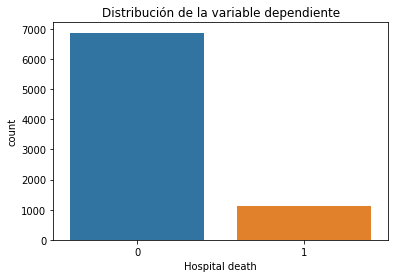

In [0]:
#Visualizamos los datos!
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.title('Distribución de la variable dependiente')
sns.countplot(x="hospital_death", data=pd_data)
plt.xlabel('Hospital death')
plt.show()

In [0]:
print(pd_data['hospital_death'].value_counts()) #Explorando el total de registros (0:death, 1:survived)

0    6878
1    1122
Name: hospital_death, dtype: int64


Como se puede observar, el 85.98% de los pacientes sobreviviendo después de estar en alguna ICU, mientras que el 14.03% de los pacientes no sobrevivieron. Debido a que nuestro objetivo es predecir cuando el paciente va a fallecer, entonces la clase de análisis debería ser mayor. A esto se le conoce como "desbalance de clases". Más adelante, trataremos de solucionar este problema.
Continuemos visualizando los datos

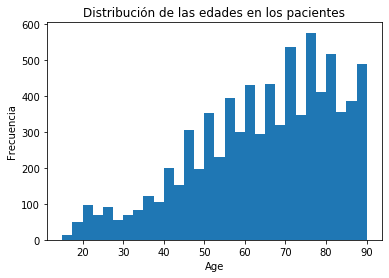

In [0]:
plt.figure(figsize=(6,4))
plt.title("Distribución de las edades en los pacientes")
plt.hist(pd_data['Age'], bins = 30)
plt.ylabel('Frecuencia')
plt.xlabel('Age')
plt.show()

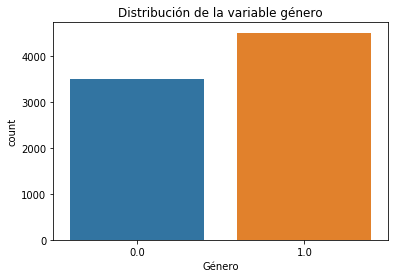

In [0]:
plt.figure(figsize=(6,4))
sns.countplot(x="Gender", data=pd_data) #0: femenino, 1: masculino
plt.title('Distribución de la variable género')
plt.xlabel('Género')
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


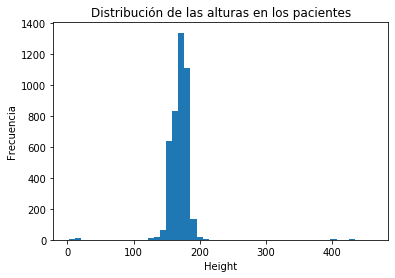

In [0]:
plt.title("Distribución de las alturas en los pacientes")
plt.hist(pd_data['Height'], bins = 50)
plt.ylabel('Frecuencia')
plt.xlabel('Height')
plt.show()

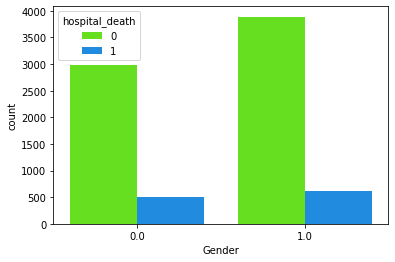

In [0]:
sns.countplot(data=pd_data,x='Gender',hue='hospital_death',palette='gist_rainbow')
plt.show()

In [0]:
#Ahora visualizamos variables dinámicas
#plt.hist(obtain_features['Temp'], bins = 3)
#plt.show()

In [0]:
print(pd_data[['HR','Albumin']]) # Visualizando dos columnas

                                                     HR     Albumin
0     [73.0, 77.0, 60.0, 62.0, 80.0, 74.0, 73.0, 64....         NaN
1     [88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88....         NaN
2     [100.0, 78.0, 96.0, 81.0, 102.0, 86.0, 87.0, 1...  [2.7, 2.3]
3     [79.0, 76.0, 74.0, 75.0, 75.0, 88.0, 78.0, 86....       [4.4]
4     [93.0, 84.0, 94.0, 87.0, 82.0, 82.0, 86.0, 84....       [3.3]
...                                                 ...         ...
7995  [110.0, 110.0, 110.0, 109.0, 103.0, 106.0, 111...         NaN
7996  [97.0, 107.0, 105.0, 107.0, 110.0, 103.0, 100....         NaN
7997  [65.0, 73.0, 66.0, 71.0, 75.0, 79.0, 69.0, 70....       [2.8]
7998  [115.0, 117.0, 122.0, 117.0, 117.0, 118.0, 115...         NaN
7999  [59.0, 58.0, 64.0, 70.0, 66.0, 64.0, 69.0, 70....         NaN

[8000 rows x 2 columns]


In [0]:
# Observemos la variable 'Albumin', e identificamos que tienen datos faltantes
#¿Cómo saber si en la base de datos hay datos faltantes en las variables clínicas?

missing_values_count = pd_data.isnull().sum() #isnull detecta valores ausentes en los registros

dict = {}
dict = missing_values_count
print(sorted(dict.iteritems(), key = lambda x : x[1])) #listamos todas las variables y el número de datos ausentes

[('Age', 0), ('ICUType', 0), ('Weight', 0), ('hospital_death', 0), ('Gender', 8), ('BUN', 120), ('Creatinine', 120), ('HCT', 124), ('HR', 128), ('GCS', 129), ('Temp', 129), ('Platelets', 130), ('HCO3', 137), ('Na', 138), ('WBC', 139), ('K', 169), ('Mg', 186), ('Glucose', 201), ('NISysABP', 973), ('NIDiasABP', 999), ('NIMAP', 1003), ('pH', 1929), ('PaCO2', 1965), ('PaO2', 1966), ('DiasABP', 2390), ('SysABP', 2390), ('MAP', 2402), ('FiO2', 2581), ('MechVent', 2960), ('Lactate', 3602), ('Height', 3824), ('SaO2', 4455), ('AST', 4539), ('ALT', 4544), ('Bilirubin', 4554), ('ALP', 4621), ('Albumin', 4754), ('RespRate', 5772), ('TroponinT', 6195), ('Cholesterol', 7352), ('TroponinI', 7614)]


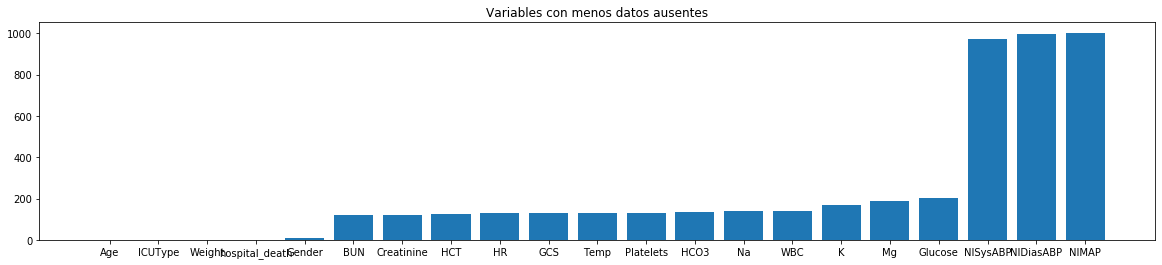

In [0]:
#Observamos que, del total de variables, 21 tienen menos datos ausentes
list = sorted(dict.items(), key = lambda x : x[1])
vars_menos_ausentes = list[:21]

plt.figure(figsize=(20,4))
plt.title("Variables con menos datos ausentes")
x, y = zip(*vars_menos_ausentes)
plt.bar(x, y)
plt.show()

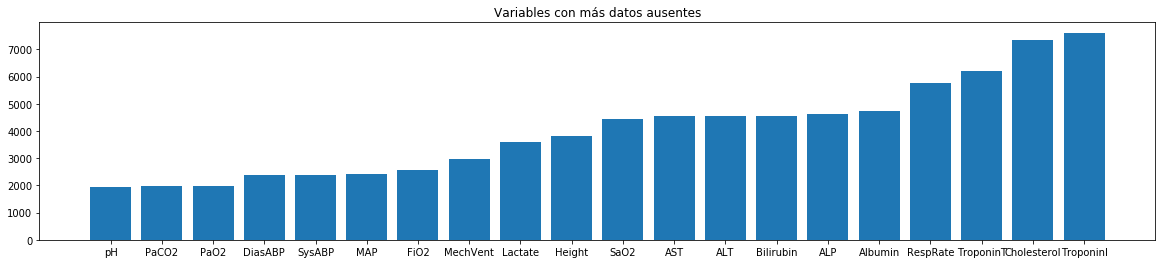

In [0]:
#Observamos que, del total de variables, 20 de estas tienen menos datos ausentes
list = sorted(dict.items(), key = lambda x : x[1])
vars_mas_ausentes = list[21:]

plt.figure(figsize=(20,4))
plt.title("Variables con más datos ausentes")
x, y = zip(*vars_mas_ausentes)
plt.bar(x, y)
plt.show()

#### Hallazgos en el análisis de datos:

- De las 42 variables, existen 13 variables que tienen una tasa de ausencia muy alta ('RespRate':5772, 'TroponinT': 6195, 'Cholesterol': 7352). Más de la mitad de los registros no tienen estas mediciones.
    - ¿Qué debemos hacer: mantener todas las variables o descartar aquellas con tasa de ausencia muy alta?
- En relación a la distribución de la población, tenemos que 6,878 (85.97%) pacientes sobrevivieron después de estar en una ICU, mientras que 1,122 (14.02%) pacientes no sobrevivieron.
    - Si construimos un modelo con esta distribución ¿creen que el modelo tendrá un buen rendimiento para predecir mortalidad?
- Se observó que hay diferentes escalas de medición entre las características. Por ejemplo, la edad está dada en años, mientras que el ritmo cardiaco (HR) está dado en bpm (latidos por minuto). Esta diferencia de escalas puede generar que se de más importancia a algunas variables frente a otras. 
    - Por tal motivo, aplicaremos una normalización. Es decir, unificaremos la escala para todas las características, de manera que no influyan de más al momento de la clasificación.
- Se observó errores al momento de la captura de los datos, por ejemplo, existen casos que se registró: 1.8 para referirse a 180cm o casos que se registró: 81.8 inch para referirse a 180cm

A continuación, vamos a pre-procesar los datos con el objetivo de atender los puntos mencionados con anterioridad.

## Paso 4: Pre-procesamiento
El rendimiento de los algoritmos de aprendizaje dependen en gran medida de la calidad de los datos.Por cada variable dinámica vamos a obtener el valor mínimo, el valor máximo, el promedio de todas las mediciones registradas, la primera y la última medición registrada, así como la diferencia entre ellas.

In [0]:
def set_features_to_nan(name):
  """
  Si el valor de una variable no fue registrado, le asignaremos NAN
  """
  values_features = {}
  values_features['{}_min'.format(name)] = np.nan
  values_features['{}_max'.format(name)] = np.nan
  values_features['{}_mean'.format(name)] = np.nan
  values_features['{}_first'.format(name)] = np.nan
  values_features['{}_last'.format(name)] = np.nan
  values_features['{}_diff'.format(name)] = np.nan
  return values_features

vars_estaticas_less = ['Age', 'ICUType', 'Gender']
vars_dinamicas_less = ['Weight', 'BUN', 'Creatinine', 'HCT','HR', 'GCS', 'Temp', 'Platelets', 'HCO', 
                       'Na', 'WBC', 'K', 'Mg', 'Glucose', 'NISysABP', 'NIDiasABP', 'NIMAP', 'pH', 
                       'PaCO', 'PaO', 'DiasABP', 'SysABP', 'MAP', 'FiO', 'MechVent', 'Lactate', 'Height']

def features_series(data):
    """ Función para ajustar las variables de la base de datos """
    pre_features = {}
    pre_values_features = {}
    age_value = []
    missing_weight = False
    for name in vars_estaticas_less:
        valor = float(data[name][0][1])
        if valor < 0: #si en las variables estáticas, el valor no fue registrado, entonces colocamos NAN
            pre_features[name] = np.nan
        elif name == "Age" and valor > 90:#Para ajustar el rango de edades
            pre_features[name] = 91.4 #aquellas edades mayores a 90, las reemplazamos a 91.4 (HIPAA)
        elif name == "Height" and valor < 10:
            pre_features[name] = valor * 100 #existen casos que se registró: 1.8 para referirse a 180cm
        elif name == "Height" and valor < 25:
            pre_features[name] = valor * 10 #existen casos que se registró: 18 para referirse a 180cm
        elif name == "Height" and valor < 100:
            pre_features[name] = valor * 2.2 #existen casos que se registró: 81.8 inch para referirse a 180cm
        elif name == "Height" and valor > 1000:
            pre_features[name] = valor * 0.1 #existen casos que se registró: 1800 para referirse a 180cm
        elif name == "Height" and valor > 250:
            pre_features[name] = valor * 0.3937 #existen casos que se registró: 400 para referirse a 157cm
        else:
            pre_features[name] = float(data[name][0][1])
    for parameter in vars_dinamicas_less:
        if parameter in data:
            values = [float(d[1]) for d in data[parameter]]
            if not values: #en caso de que la variable este vacía llenarla con NAN
                missing_weight = True
                pre_values_features = set_features_to_nan(parameter)
            else: #cada variable 
                pre_values_features['{}_min'.format(parameter)] = min(values)
                pre_values_features['{}_max'.format(parameter)] = max(values)
                pre_values_features['{}_mean'.format(parameter)] = np.mean(values)
                pre_values_features['{}_first'.format(parameter)] = values[0]
                pre_values_features['{}_last'.format(parameter)] = values [-1]
                pre_values_features['{}_diff'.format(parameter)] = values[-1] - values[0]
        pre_features.update(pre_values_features)
    return pre_features

def preprocessing(data_icu):
    pre_features = []
    count_missing_weight = 0
    for id, data in data_icu.items(): # retorna una copia del diccionario
        feats = features_series(data)
        pre_features.append(feats)
    return pre_features

pre_features = preprocessing(data_icu)
pre_features = pd.DataFrame(pre_features)
print(pre_features)

       Age  ICUType  Gender  ...  Lactate_first  Lactate_last  Lactate_diff
0     54.0      4.0     0.0  ...            NaN           NaN           NaN
1     76.0      2.0     1.0  ...            NaN           NaN           NaN
2     44.0      3.0     0.0  ...            1.3           0.9          -0.4
3     68.0      3.0     1.0  ...            NaN           NaN           NaN
4     88.0      3.0     0.0  ...            NaN           NaN           NaN
...    ...      ...     ...  ...            ...           ...           ...
7995  78.0      2.0     1.0  ...            1.1           1.1           0.0
7996  90.0      3.0     1.0  ...            5.8           1.3          -4.5
7997  70.0      2.0     0.0  ...            1.4           1.4           0.0
7998  49.0      3.0     0.0  ...            4.5           4.5           0.0
7999  82.0      2.0     0.0  ...            7.5           1.3          -6.2

[8000 rows x 141 columns]


## Paso 5: Construcción del modelo de predicción
Ahora, vamos a construir nuestro primero modelo para predecir la mortalidad de un paciente en una UCI, tomando en cuenta las mediciones obtenidas previamente.

In [0]:
#Separamos los datos en dos conjuntos: entrenamiento y prueba
all_data = pd.concat([pre_features, labels], axis = 1, sort = False)
x_all = all_data.drop('hospital_death', axis = 1) #features
y_all = all_data.hospital_death #label
feature_list = x_all.columns
print(len(feature_list)) #Tenemos 141 features

#all_data.to_csv("../data/test_set.csv")

141


A continuación vamos a definir un par de funciones. 
- La primera función servirá para imputar los datos faltantes con la media. Esto consiste en inferir los datos faltantes a partir de los datos conocidos, en nuestro caso usaremos la media.
- La segunda función servirá para la normalización. La idea detrás de StandardScaler es transformar los datos de modo que su distribución tendrá una media = 0 y una desviación estándar de 1.

In [0]:
from sklearn.preprocessing import StandardScaler #normalizar datos
from sklearn.impute import SimpleImputer #imputando con la media

def imputer(set):
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    set = imputer.fit_transform(set) ##imputando con la media
    return set

def scaler(set):
    scaler = StandardScaler() #normalizar datos
    set = scaler.fit_transform(set)
    return set

x_all = imputer(x_all)
#x_all = scaler(x_all)

#--- Normalizamos las etiquetas
from sklearn import preprocessing
le = preprocessing.LabelEncoder() #Codificamos las etiquetas con valor entre 0 y 1
y_all = le.fit_transform(y_all)


In [0]:
#Para clases desbalanceadas
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight


### Fine-tuning

Este paso consiste en tomar los pesos de una red neuronal entrenada y usarlos como inicialización para entrenar un nuevo modelo.

In [0]:
#!pip3 install xgboost
#!pip3 install lightgbm
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=422) #división de los datos
sample_weights = class_weight.compute_sample_weight('balanced', y_train)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train==1)
cv = StratifiedKFold(n_splits=3)

""" Fine-tunning """

estimators = {
    'RandomForestClassifier': RandomForestClassifier(random_state = 442),
    'XGBClassifier': XGBClassifier(seed = 442,eval_metric = 'auc', scale_pos_weight = ratio),
    'LogisticRegression': LogisticRegression(random_state = 442),
    'Light':lgb.LGBMClassifier(seed = 442)
}

params = {
    'RandomForestClassifier':{ 
            "n_estimators"      : [20,80],
            "max_depth":[6,7,8],
            "class_weight":['balanced']
            },
    'XGBClassifier': {
        "n_estimators":[100], "learning_rate": [0.15,0.25],
        "colsample_bytree" : [0.8],
        "subsample" : [0.8, 0.4], "reg_alpha" : [0.5], "reg_lambda": [2],
        "objective": ['binary:logistic'], "max_depth":[4,2], 
        "rate_drop": [0.5, 0.3],"gamma":[10]
        },
    'LogisticRegression': {
        "C":np.logspace(-3,3,7), 
        "penalty":["elasticnet"],
        "solver":['saga'], 
        "l1_ratio":[0.5],
        "class_weight": ['balanced']
        },
    'Light':{"objective": ['binary'],"learning_rate":[0.1,0.9],
            "metric":['auc'], "max_bin":[130], 
            "feature_fraction":[0.8, 0.6],"min_data_in_bin":[1],
            "max_depth":[10,2],"min_data_in_leaf": [10],
            "min_sum_hessian_in_leaf":[1e-10],"drop_rate":[0.5],
            "bagging_fraction":[0.5,1.0],"num_leaves":[31],
            "boost_from_average":['true'],"lambda_l2":[0.09, 0.9],
            "min_gain_to_split":[10], "is_unbalance" : ['true'],
            "num_iterations":[200]
    }
}
for name in estimators.keys():
    est = estimators[name]
    est_params = params[name]
    clf = GridSearchCV(estimator=est, param_grid=est_params, cv=cv,
                      scoring='roc_auc', iid="warn", refit = True)
    clf.fit(x_train, y_train,sample_weight = sample_weights)
    print("best parameters are: {}".format(clf.best_estimator_))
    print("{} best AUC: {}".format(name,clf.best_score_))

best parameters are: RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=80, n_jobs=None, oob_score=False,
                       random_state=442, verbose=0, warm_start=False)
RandomForestClassifier best AUC: 0.8084341439500858
best parameters are: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
              gamma=10, learning_rate=0.15, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              rate_drop=0.5, reg_alpha=0.5, re

## Paso 6: Entrenamiento del modelo
Una vez que hemos identificado los mejores parámetros y pesos, entrenamos el modelo.

In [0]:
def compute_auc(model, x,y):
    """Función que calcula el área bajo la curva ROC"""
    y_predicted = model.predict(x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_predicted)
    auc_score = auc(false_positive_rate, true_positive_rate)
    return auc_score,false_positive_rate,true_positive_rate

In [0]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

""" Configuramos el modelo con la mejor combinación de parámetros obtenidos"""
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                      colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
                      gamma=10, learning_rate=0.15, max_delta_step=0, max_depth=2,
                      min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                      nthread=None, objective='binary:logistic', random_state=0,
                      rate_drop=0.5, reg_alpha=0.5, reg_lambda=2,
                      scale_pos_weight=6.239819004524887, seed=442, silent=None,
                      subsample=0.8, verbosity=1)
model = model.fit(x_train,y_train)
  
#Calculamos el AUC con el conjunto de validación
auc_val,_,_ = compute_auc(model, x_val,y_val)
print("AUC de validación: ",auc_val)

AUC de validación:  0.7799516282283838


## Paso 7: Evaluación final

In [0]:
def read_data(raw_clinical_note):
    data = pd.read_csv(raw_clinical_note, header=0,na_filter=True)
    col = data.columns
    x = data.drop('hospital_death', axis = 1) #features
    y = data.hospital_death #label
    #feature_list = list(x.columns)
    return x, y

x_test, y_test = read_data("/content/DAMA_EHR19/data/test_set.csv")
x_test = imputer(x_test)

#Calculamos el AUC con el conjunto de prueba
auc_test,fpr,tpr = compute_auc(model,x_test,y_test)
print("AUC de prueba: ",auc_test)

AUC de prueba:  0.7539099748470173


## Paso 8: Curva ROC

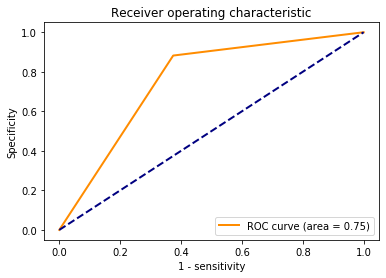

In [0]:
plt.figure()
lw = 2
plt.plot(fpr, tpr,color='darkorange',
         lw=lw,label='ROC curve (area = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('1 - sensitivity')
plt.ylabel('Specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Paso 9: Importancia de las características


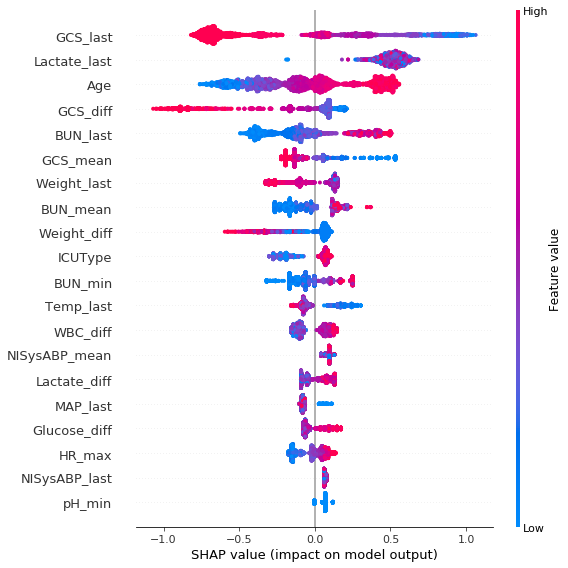

In [0]:
#!pip3 install graphviz
#!pip3 install xgboost
#!pip3 install shap

import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, feature_names=feature_list, class_names=['survive','death'])

In [0]:
#Evaluación de características con RF:
#!pip3 install dtreeviz
#from dtreeviz.trees import *
#viz = dtreeviz(model[1],x_train,y_train,
#                    target_name='hospital_expire_flag',
#                    feature_names=feature_list,
#                    orientation ='TD',  # left-right orientation
#                    class_names=["Died", "Survive"],
#                    fancy = False)
#viz.view()

[0]	val-error:0.39
Will train until val-error hasn't improved in 20 rounds.
Stopping. Best iteration:
[133]	val-error:0.2175



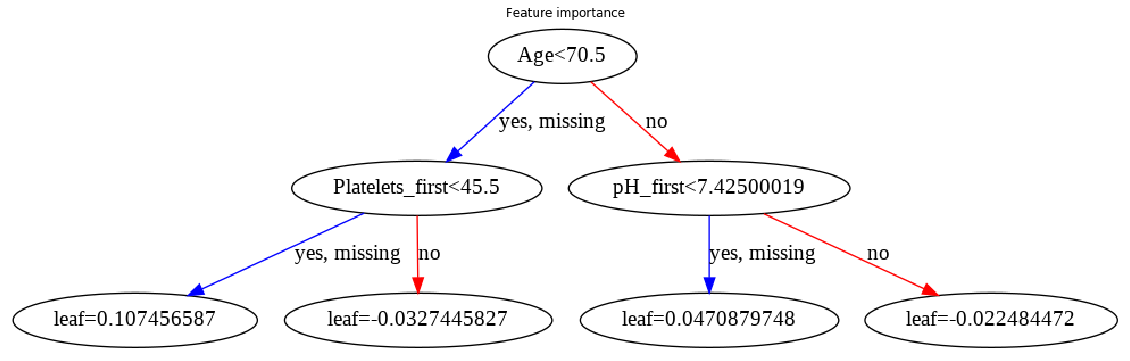

In [0]:
import xgboost
import matplotlib.pylab as pl

#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#Visualización de features con XGBT
params={"n_estimators":100, "learning_rate": 0.15,"colsample_bytree" : 0.8,
         "subsample" : 0.8, "reg_alpha" : 0.5, "reg_lambda": 2,
         "objective": "binary:logistic", "max_depth":2,
         "gamma": 10,"rate_drop": 0.5 , "scale_pos_weight" : 6.239819004524887}


d_train = xgboost.DMatrix(x_train, label=y_train, feature_names=feature_list)
d_val = xgboost.DMatrix(x_val, label=y_val, feature_names=feature_list)
d_test = xgboost.DMatrix(x_test, label=y_test, feature_names=feature_list)
model_ehr = xgboost.train(params, d_train, 5000, evals = [(d_val, "val")], 
                          verbose_eval=1000, 
                          early_stopping_rounds=20)

xgboost.plot_tree(model_ehr, num_trees = 99)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.title("Feature importance")
plt.show()